# Abstract

In [1]:
# code

In [2]:
# imports

# misc
import datetime
import os, sys, shutil

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from tqdm import tqdm

# charting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# for darksky api
import json
import requests

In [3]:
# load the data
df_train = pd.read_csv('source_data/dengue_features_train.csv') 

In [4]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
train_labels = pd.read_csv('source_data/dengue_labels_train.csv')

In [6]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [7]:
train_labels['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

In [8]:
df_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [27]:
df_sj = df_train[df_train['city'] == 'sj']
df_iq = df_train[df_train['city'] == 'iq']

In [47]:
print("sj length: {}".format(len(df_sj)))
print("iq length: {}".format(len(df_iq)))

sj length: 936
iq length: 520


In [49]:
# https://www.pythonprogramming.in/get-the-day-of-week-from-given-a-date-in-python.html
# Python's program to get the day of week of today or given date.
 
dayofweek = datetime.date(2010, 6, 16).strftime("%A")
print(dayofweek)
# weekday Monday is 0 and Sunday is 6
print("weekday():", datetime.date(2010, 6, 16).weekday())
 
# isoweekday() Monday is 1 and Sunday is 7
print("isoweekday()", datetime.date(2010, 6, 16).isoweekday())
 
dayofweek = datetime.datetime.today().strftime("%A")
print(dayofweek)
print("weekday():", datetime.datetime.today().weekday())
print("isoweekday()", datetime.datetime.today().isoweekday())

Wednesday
weekday(): 2
isoweekday() 3
Wednesday
weekday(): 2
isoweekday() 3


In [ ]:
dayofweek

In [50]:
df_sj['week_start_date'].head(10)

0    1990-04-30
1    1990-05-07
2    1990-05-14
3    1990-05-21
4    1990-05-28
5    1990-06-04
6    1990-06-11
7    1990-06-18
8    1990-06-25
9    1990-07-02
Name: week_start_date, dtype: object

In [54]:
df_sj.tail(10)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
926,sj,2008,8,2008-02-19,-0.13865,-0.095067,0.246057,0.228129,0.00,297.907143,...,8.30,74.785714,0.00,14.538571,1.885714,24.900000,5.785714,28.3,21.7,13.3
927,sj,2008,9,2008-02-26,NaN,0.015420,0.211629,0.117343,0.00,297.765714,...,6.46,72.660000,0.00,13.967143,2.285714,24.742857,5.500000,27.8,21.1,12.9
928,sj,2008,10,2008-03-04,-0.08890,-0.090033,0.223243,0.154186,0.00,297.878571,...,6.50,74.681429,0.00,14.474286,2.614286,25.114286,6.114286,29.4,21.1,13.0
929,sj,2008,11,2008-03-11,-0.32140,-0.141200,0.110643,0.141014,0.00,297.595714,...,9.38,71.934286,0.00,13.721429,2.085714,25.328571,5.814286,28.9,22.2,4.4
930,sj,2008,12,2008-03-18,0.04490,0.024450,0.101629,0.088000,0.00,297.404286,...,0.90,72.915714,0.00,13.737143,3.871429,25.200000,7.042857,30.0,20.6,0.5
931,sj,2008,13,2008-03-25,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,sj,2008,14,2008-04-01,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,sj,2008,15,2008-04-08,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,sj,2008,16,2008-04-15,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,sj,2008,17,2008-04-22,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [55]:
df_iq.head(10)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
941,iq,2000,31,2000-08-05,0.205529,0.190757,0.231671,0.255314,16.24,297.191429,...,1.00,74.728571,16.24,13.421429,13.771429,25.340000,10.940000,32.0,17.0,11.5
942,iq,2000,32,2000-08-12,0.312486,0.329986,0.380586,0.387271,89.37,297.320000,...,26.68,83.275714,89.37,15.311429,11.471429,27.016667,11.650000,34.0,19.9,72.9
943,iq,2000,33,2000-08-19,0.384133,0.392240,0.341780,0.382750,42.08,297.627143,...,16.90,82.490000,42.08,15.465714,13.700000,26.583333,10.316667,33.0,20.5,50.1
944,iq,2000,34,2000-08-26,0.408157,0.322157,0.406714,0.302714,49.22,298.238571,...,5.59,74.740000,49.22,14.444286,13.771429,26.900000,13.400000,34.0,19.0,89.2
945,iq,2000,35,2000-09-02,0.332043,0.321057,0.314614,0.324257,53.65,299.218571,...,16.07,74.151429,53.65,15.057143,12.457143,27.116667,12.266667,34.0,20.0,78.0


In [56]:
df_iq.tail(10)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1446,iq,2010,16,2010-04-23,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,...,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1
1447,iq,2010,17,2010-04-30,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1448,iq,2010,18,2010-05-07,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1
1449,iq,2010,19,2010-05-14,0.168686,0.158500,0.133071,0.145600,59.40,297.278571,...,87.30,97.445714,59.40,18.391429,6.185714,27.400000,10.400000,33.7,21.2,32.0
1450,iq,2010,20,2010-05-21,0.263071,0.272500,0.258271,0.244500,1.15,297.648571,...,8.80,78.998571,1.15,14.908571,11.242857,25.633333,9.200000,34.0,20.0,2.5
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [44]:
sj_start_week = df_sj['weekofyear'][df_sj['year'] == 1990]
sj_end_week = df_sj['weekofyear'][df_sj['year'] == 2008]

iq_start_week = df_iq['weekofyear'][df_iq['year'] == 2000]
iq_end_week = df_iq['weekofyear'][df_iq['year'] == 2010]

In [45]:
iq_start_week.describe()

count    26.000000
mean     38.500000
std       7.648529
min      26.000000
25%      32.250000
50%      38.500000
75%      44.750000
max      51.000000
Name: weekofyear, dtype: float64

In [46]:
print('sj min: {}'.format(sj_start_week.min()))
print('sj max: {}'.format(sj_end_week.max()))

print('iq min: {}'.format(iq_start_week.min()))
print('iq max: {}'.format(iq_start_week.max()))

sj min: 18
sj max: 17
iq min: 26
iq max: 51


In [ ]:
# sj starts in week 18 of 1990 and ends week 17 of 2008
# iq starts in week 26 of 2000 and ends week 51 of 2010

# estimates of the number of api calls to darksky:
# sj = 35 weeks in 1990 + 52 weeks 1991 - 2008 + 17 weeks in 2008 = 988 weeks x 7 days = 6,916
# iq = 27 weeks in 2000 + 52 weeks 2001 - 2009 + 51 weeks in 2010 = 546 weeks x 7 days = 3,822
# total = 10,738 whcih means 11 days of 1K/day

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [9]:
df_train['total_cases'] = train_labels['total_cases']

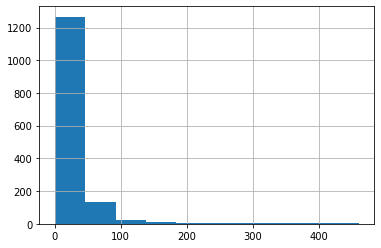

In [10]:
df_train['total_cases'].hist()

In [11]:
df_train.iloc[:,4:12].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000


In [26]:
df_train.iloc[:,12:18].describe()

,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg
count,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000
mean,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427
std,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494
min,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714
25%,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143
50%,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143
75%,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214
max,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429


In [25]:
df_train.iloc[:,18:24].describe()

,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


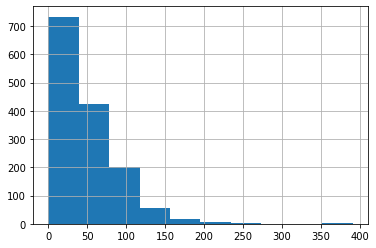

In [13]:
df_train.precipitation_amt_mm.hist()

In [14]:
# get darksky.net historical weather information

# request format:  https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]

# San Juan, Puerto Rico - Latitude: 18.4653, Longitude: -66.1167
# Iquitos, Peru:  - Latitude: -3.74937, Longitude: -73.2444




In [20]:
# SF: 37.7648, -122.463

# this gets current SF weather forecast
target = 'https://api.darksky.net/forecast/9501b92a37587155d222ae11b77c65a3/37.63474, -122.109015'

# target = 'https://api.darksky.net/forecast/9501b92a37587155d222ae11b77c65a3/42.3601,-71.0589,255657600?exclude=currently,flags'
req = requests.get(url=target)

json_data = json.loads(req.text)

print(json.dumps(json_data, indent=4, sort_keys=True))



{
    "currently": {
        "apparentTemperature": 73.23,
        "cloudCover": 0.05,
        "dewPoint": 55.7,
        "humidity": 0.54,
        "icon": "clear-day",
        "nearestStormBearing": 63,
        "nearestStormDistance": 263,
        "ozone": 298.8,
        "precipIntensity": 0,
        "precipProbability": 0,
        "pressure": 1018.23,
        "summary": "Clear",
        "temperature": 73.23,
        "time": 1568225464,
        "uvIndex": 6,
        "visibility": 10,
        "windBearing": 281,
        "windGust": 5.27,
        "windSpeed": 3.02
    },
    "daily": {
        "data": [
            {
                "apparentTemperatureHigh": 83.84,
                "apparentTemperatureHighTime": 1568239200,
                "apparentTemperatureLow": 57.27,
                "apparentTemperatureLowTime": 1568289600,
                "apparentTemperatureMax": 83.84,
                "apparentTemperatureMaxTime": 1568239200,
                "apparentTemperatureMin": 57.78,
     

Strategy for additional environmental data:
Collect the dark sky data into a seperate dataframe with daily values for each city
# double check these dates

San Juan first week start date is 1990-04-30 (Monday)
San Juan last week start date is 2008-04-22 (Tuesday)

Iquitos first week start date is 2000-07-01 (Saturday)
Iquitos last week start date is 2010-06-25 (Friday)

The San Juan data is weekly and begins on Monday 1990-04-30 @ 12:00 AM and ends on Sunday 2008-04-28 @ 11:59 PM 
*** there appears to be a discrepancy in the weekly start day from the beginning to the end

The Iquitos data is weekly and begins on Saturday 2000-07-01 @ 12:00 AM and ends on Friday 2010-07-02 @ 11:59 PM
*** there appears to be a discrepancy in the weekly start day from the beginning to the end

I have read that mosquito eggs can stay viable for over a decade, hatching when conditions are acceptable.

I am choosing to gather additional weather data for 1 year prior to the start dates above, so the dates I want weather data for are:

San Juan: 1989-05-01 to 2008-04-28
Iquitos:  1999-06-30 to 2010-07-02


In [66]:
sj_elapsed = pd.Timestamp(sj_end)  - pd.Timestamp(sj_start)
iq_elapsed = pd.Timestamp(iq_end) - pd.Timestamp(iq_start)

In [67]:
print(sj_elapsed)
print(iq_elapsed)

6937 days 00:00:00
4020 days 00:00:00


In [ ]:
# psuedo code for getting the darksky data at 1K/day

# each record in the training set has the city code and the start day of that week
# convert the start day of week to UNIX epoch timestamp at the city of the record, 
# ie. 2009-04-30 becomes 641433600 (midnight on 4/30/2009)


# make 7 calls to the api, incrementing each by 
# 
# set start year and day for sj and iq
# set end year and day for sj and iq
# make weather_data_df with two columns: index(auto), city, datetime
# for index in weather_data_df:
#   create the url
#   call the api
#   write the data to a df
#   save the df as a csv
# 


In [84]:
# variables
# San Juan, Puerto Rico - Latitude: 18.4653, Longitude: -66.1167
# Iquitos, Peru:  - Latitude: -3.74937, Longitude: -73.2444


darksky_key = '9501b92a37587155d222ae11b77c65a3'

sj_lat = 18.4653
sj_lon = -66.1167
iq_lat = -3.74937
iq_lon = -73.2444

sj_start = '1989-05-01'
sj_end = '2008-04-28'
iq_start = '1999-06-30'
iq_end = '2010-07-02'

sj_elapsed = pd.Timestamp(sj_end)  - pd.Timestamp(sj_start)
iq_elapsed = pd.Timestamp(iq_end) - pd.Timestamp(iq_start)

sj_day_count = sj_elapsed.days
iq_day_count = iq_elapsed.days


In [147]:
sj_day_list = pd.date_range(sj_start, periods=sj_day_count, freq='D')
iq_day_list = pd.date_range(iq_start, periods=iq_day_count, freq='D')

In [148]:
# len(sj_day_list
# len(iq_day_list)

In [149]:
# sj_darksky = pd.DataFrame()
# iq_dasksky = pd.DataFrame()



In [150]:
sj_days_df = pd.DataFrame(sj_day_list.astype(str))
iq_days_df = pd.DataFrame(iq_day_list.astype(str))


In [190]:
sj_days_df.head()

,date
0,1989-05-01
1,1989-05-02
2,1989-05-03
3,1989-05-04
4,1989-05-05


In [171]:
sj_days_df.columns


TypeError: 'RangeIndex' object is not callable

In [182]:
# sj_days_df.iloc[0]

temp_list = []
for index, date in enumerate(sj_days_df):
    print(date)
#     temp_list.append(date)
    
# temp_list

0


In [221]:
def get_darksky_data(key, latitude, longitude, days_df, start_index, count):
    current_index = start_index
    for i in range(count):
        day = days_df.iloc[current_index]['date']
        day_string = day + 'T00:00:00'
#         print(day_string)
        target = 'https://api.darksky.net/forecast/' + darksky_key + '/' + str(latitude) + ',' + str(longitude) + ',' + day_string + '?exclude=currently,hourly,flags'
#         print(target)
        req = requests.get(url=target)
        json_data = json.loads(req.text)
        print(json.dumps(json_data, indent=4, sort_keys=True))
        current_index += 1


In [222]:
# sj_days_df.columns = (['date'])

In [223]:
# sj_days_df.columns

In [224]:
get_darksky_data(darksky_key, sj_lat, sj_lon, sj_days_df, 0, 3)

1989-05-01T00:00:00
https://api.darksky.net/forecast/9501b92a37587155d222ae11b77c65a3/18.4653,-66.1167,1989-05-01T00:00:00?exclude=currently,hourly,flags
{
    "daily": {
        "data": [
            {
                "apparentTemperatureHigh": 88.2,
                "apparentTemperatureHighTime": 610048800,
                "apparentTemperatureLow": 74.07,
                "apparentTemperatureLowTime": 610095600,
                "apparentTemperatureMax": 88.2,
                "apparentTemperatureMaxTime": 610048800,
                "apparentTemperatureMin": 74.36,
                "apparentTemperatureMinTime": 610009200,
                "cloudCover": 0.41,
                "dewPoint": 70.15,
                "humidity": 0.77,
                "icon": "rain",
                "moonPhase": 0.87,
                "precipIntensity": 0.001,
                "precipIntensityMax": 0.0118,
                "precipIntensityMaxTime": 610005600,
                "precipProbability": 1,
                "pre

In [ ]:
# test of the code - 10 api calls
# https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]  # url format